In [2]:
import cv2
import numpy as np
import numpy.random as rnd
from scipy.stats import multivariate_normal
import glob
import pickle
import pdb
import matplotlib.pyplot as pl

In [3]:
fg = []
bg = []
for i in range(0, 1):
    print
    "Image %d" % i
    file_img = "./Images/t%d.jpg" % i
    file_lbl = "./lbls/l%d.png" % i
    img = cv2.imread(file_img)
    lbl = cv2.imread(file_lbl, cv2.IMREAD_GRAYSCALE)
    h, w, ch = img.shape
    # fg.append(img[lbl==255])
    # bg.append(img[lbl==0])
    for r in range(h):
        for c in range(w):
            if lbl[r, c] == 255:
                fg.append(img[r, c, :])
            else:
                bg.append(img[r, c, :])

fg = np.array(fg)
bg = np.array(bg)

prior = len(fg) / float(len(fg) + len(bg))

In [5]:
print(fg.shape)
print(bg.shape)

(86544, 3)
(1142256, 3)


In [10]:
def random_cov(D):
    # Will ensure symmetric pos. def.
    out = rnd.random((D, D))
    out *= out.T
    out += 100 * D * np.eye(D)
#     print(out.shape)
    return out

In [19]:
class GMM():
    def __init__(self, data, K):
        self.data = data
        self.D = len(data[0])
        self.n = len(data)
        self.K = K
        self.lam = np.ones(K) / K
        self.mu = rnd.random((K, self.D)) * 255.0
        self.cov = np.array([random_cov(self.D) for i in range(K)])
        self.r = np.zeros((self.n, self.K))

    def estep(self):
        K = self.K
        n = self.n
        self.setup()
        for i in range(n):
            for k in range(K):
                self.r[i, k] = self.lam[k] * (self.norm[k].pdf(self.data[i]))
            self.r[i, :] /= self.r[i, :].sum()

    def mstep(self):
        K = self.K
        D = self.D
        n = self.n
        sum_full = float(self.r.sum())
        r_sum = self.r.sum(0)
        self.lam = r_sum / sum_full
        for k in range(K):
            self.mu[k] = self.r[:, k].dot(self.data) / r_sum[k]
        for k in range(K):
            tmp = np.zeros((D, D))
            for i in range(n):
                t = self.data[i, :] - self.mu[k]
                tmp += self.r[i, k] * np.outer(t, t)
            self.cov[k] = tmp / r_sum[k]
            print("R_sum[k]: %f" % r_sum[k])

    def step(self):
        old_mu = self.mu.copy()
        print("E-Step")
        self.estep()
        print("M-Step")
        self.mstep()
        d = np.linalg.norm(old_mu - self.mu)
        print(d)
        return d

    def train(self, tol):
        d = tol
        while d >= tol:
            d = self.step()
        self.setup()

    def setup(self):
        K = self.K
        n = self.n
        self.norm = []
        for k in range(K):
            self.norm.append(multivariate_normal(mean=self.mu[k], cov=self.cov[k]))

    def probs(self, x):
        K = self.K
        n = self.n

        out = 0.0
        for k in range(K):
            out += self.lam[k] * (self.norm[k].pdf(x))
        return out
    def printCov(self):
        print(self.mu)

In [20]:
b = GMM(bg, 2)
b.printCov()
f = GMM(fg, 3)

[[144.60301162 156.24783248  69.13223441]
 [176.27859018  30.15981147  13.49623504]]


In [ ]:
print("BG")
b.train(20)

BG
E-Step


In [12]:
print("FG")
f.train(20)

FG
E-Step
M-Step
R_sum[k]: 31399.551934
R_sum[k]: 36576.573777
R_sum[k]: 18567.874288
101.54262906275645
E-Step
M-Step
R_sum[k]: 31634.985239
R_sum[k]: 35183.857274
R_sum[k]: 19725.157486
4.921158376021306


In [13]:


# For single pixels
def prob(x, b, f, prior):
    p1 = f.probs(x)
    p2 = b.probs(x)
    l1 = prior
    l2 = 1 - prior
    return (p1 * l1) / (p1 * l1 + p2 * l2)


# For full images
def prob2(x, b, f, prior):
    p1 = f.probs(x)
    p2 = b.probs(x)
    l1 = prior
    l2 = 1 - prior
    return np.divide(p1 * l1, p1 * l1 + p2 * l2)



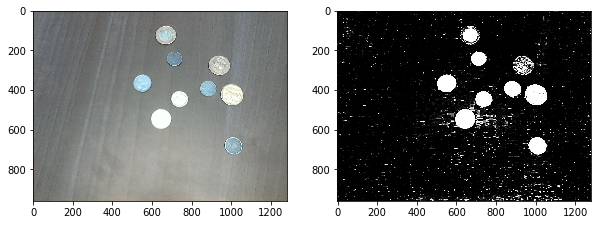

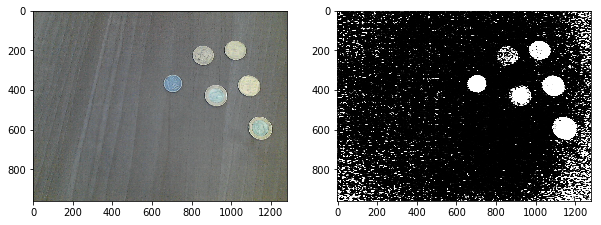

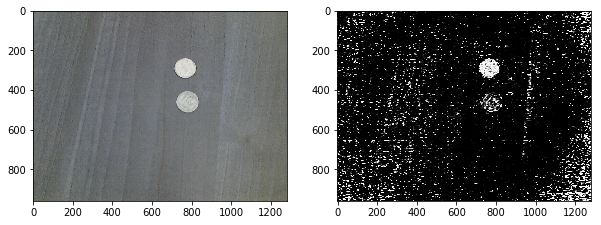

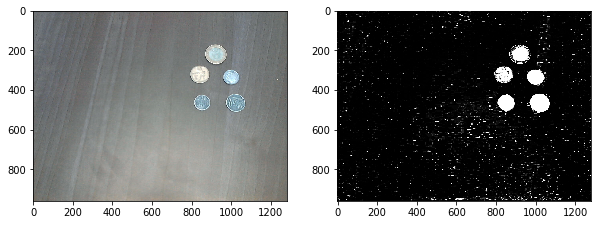

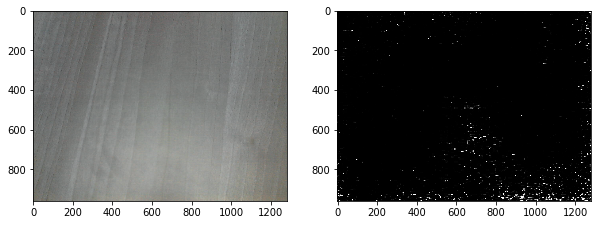

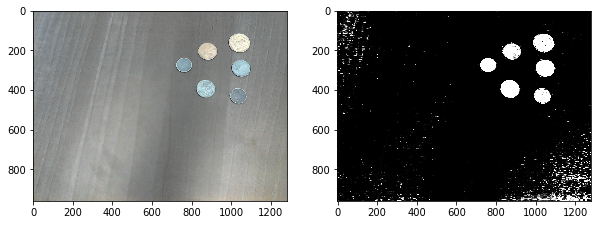

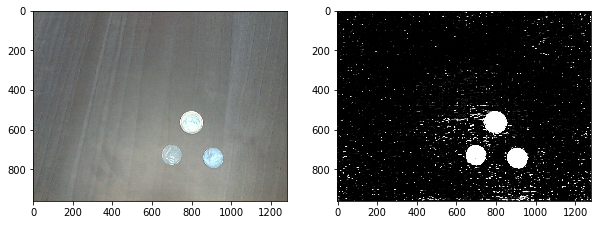

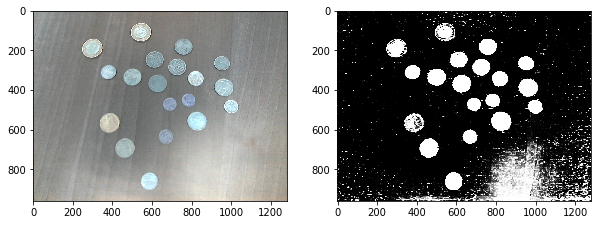

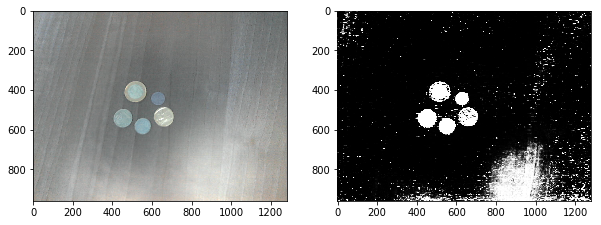

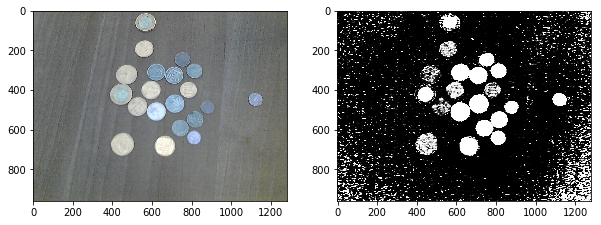

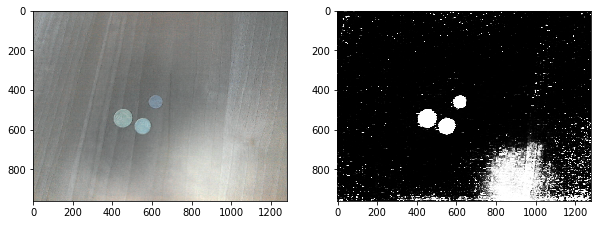

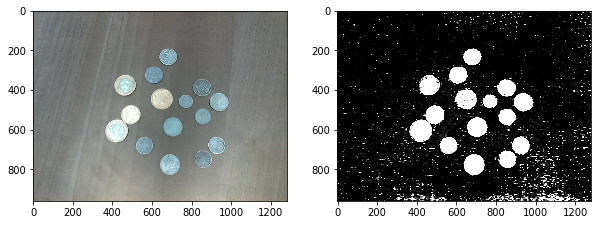

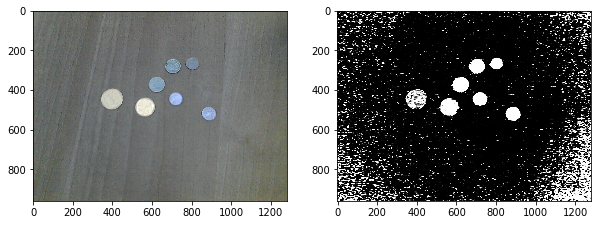

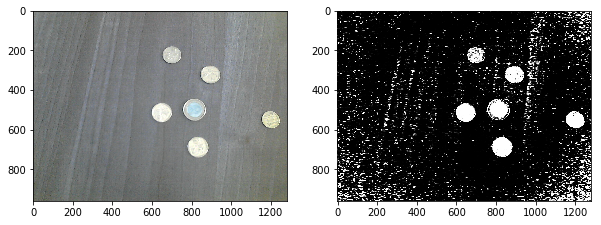

In [24]:
for i in range(1,15):
    pl.figure(figsize=(10,10))
    file_img = "./Images/t%d.jpg" % i
    img = cv2.imread(file_img)
    p = prob2(img, b, f, prior)
    pl.subplot(1, 2, 1)
    pl.imshow(img)
    pl.subplot(1, 2, 2)
    pl.imshow(p)